In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
def values(data, label):
    """
    Calculates ecdf from a 1D array.
    
    Parameters:
    data = 1D array
    label = string
    
    Returns:
    Pandas dataframe with ecdf values, labels, and x values
    """

    data = data[~np.isnan(data)]
    ecdf = pd.DataFrame(np.arange(1, len(data)+1) / len(data))
    ecdf['Label'] = label
    ecdf['Values'] = np.sort(data)
    ecdf.columns = ["ecdf", "Label", "Values"]

    return ecdf

def plot(data, label_column, val_column):
    """
    Generates ecdf plots.
    
    Parameters:
    data = tidy data with values in one column and labels in another
    label_column = column name with categories
    value_column = column name with values

    Returns:
    editable ecdf plot using matplotlib
    """
    #obtain unique values
    labels = data[label_column].unique()

    #calculate ecdf for every label
    ecdf_list = []
    for i in labels:
        sliced_data = data.loc[data[label_column] == i]
        ecdf_val = values(sliced_data[val_column].values, i)
        ecdf_list.append(ecdf_val)

    #plot ecdf
    for i in range(len(ecdf_list)):
        try: 
            plt.step(ecdf_list[i]["Values"], ecdf_list[i]["ecdf"], linewidth = 1.5, 
                     label = ecdf_list[i]["Label"][0])
        except TypeError:
            plt.step(ecdf_list[i]["Values"], ecdf_list[i]["ecdf"], linewidth = 1.5, 
                     label = ecdf_list[i]["Label"][0])
    plt.legend()

## Basic Visualizations

In [9]:
#read in dataset
data = pd.read_csv('data/data.csv')
movies = pd.read_csv('data/movies.csv')

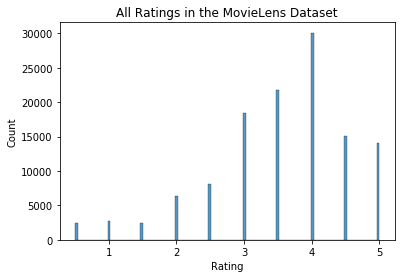

In [10]:
#lets looks at rating distribution
sns.histplot(data['Rating'], kde=False)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('All Ratings in the MovieLens Dataset')
plt.show()

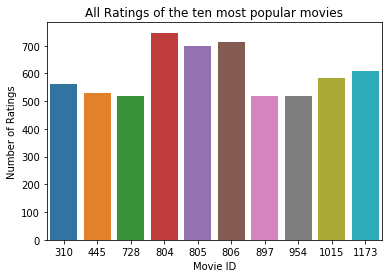

In [11]:
#get top 10 most popular movies based on number of ratings
data_grouped = data.groupby('Movie ID').agg({'Rating': 'count'}).reset_index()
data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

#plot data
sns.barplot(x='Movie ID', y='Rating', data=data_grouped)
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('All Ratings of the ten most popular movies')
plt.show()

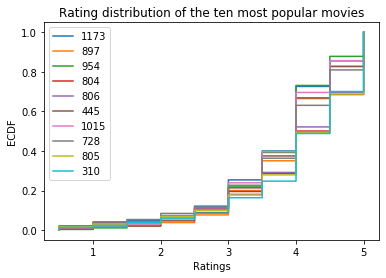

In [12]:
iso_df = data[data['Movie ID'].isin(data_grouped['Movie ID'])].reset_index(drop=True)
plot(iso_df, label_column = 'Movie ID', val_column = 'Rating')
plt.xlabel('Ratings')
plt.ylabel('ECDF')
plt.title('Rating distribution of the ten most popular movies')
plt.show()

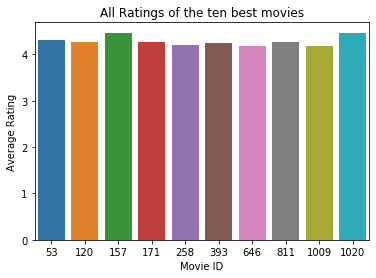

In [13]:
#get top 10 best rated movies
data_grouped = data.groupby('Movie ID').agg({'Rating': 'mean'}).reset_index()
data_grouped = data_grouped.sort_values(by='Rating', ascending=False).head(10)

sns.barplot(x='Movie ID', y='Rating', data=data_grouped)
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.title('All Ratings of the ten best movies')
plt.show()

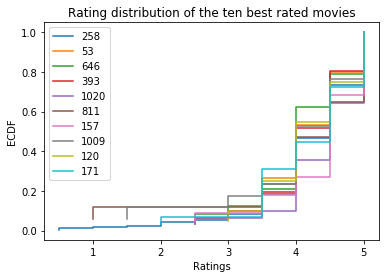

In [14]:
iso_df = data[data['Movie ID'].isin(data_grouped['Movie ID'])].reset_index(drop=True)
plot(iso_df, label_column = 'Movie ID', val_column = 'Rating')
plt.xlabel('Ratings')
plt.ylabel('ECDF')
plt.title('Rating distribution of the ten best rated movies')
plt.show()

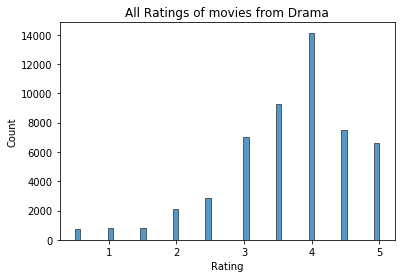

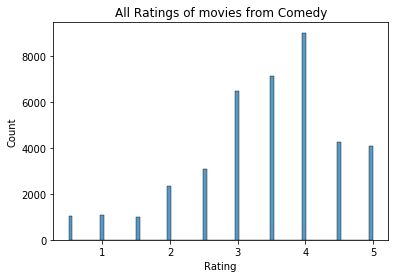

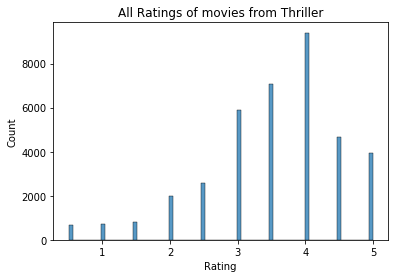

In [15]:
# Select three genres of your choice
genres = ['Drama', 'Comedy', 'Thriller']

#isolate df
df_list = []
for genre in genres:
    df_list.append(data[data['Movie ID'].isin(movies[movies[genre] == 1]['Movie ID'])])

#generate individual plots for three genres
for i, data_grouped in enumerate(df_list):
    sns.histplot(data_grouped['Rating'], kde=False)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(f'All Ratings of movies from {genres[i]}')
    plt.show()

# Method 1: Code from HW5

In [16]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    gradient = reg * Ui - ((Yij - Ui.T @ Vj)*Vj)
    update = Ui - (eta*gradient)

    return update

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    gradient = reg * Vj - ((Yij - Ui.T @ Vj)*Ui)
    update = Vj - (eta*gradient)

    return update

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    _sum = 0
    for i,j,y in Y:
        i = int(i)
        j = int(j)
        error = (y - (U[i,:] @ V.T[:,j]))**2
        _sum += error
    loss = ((reg/2 * (np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2)) + _sum/2)/len(Y)

    return loss

def train_model(M, N, K, eta, reg, Y, eps= 0.01, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    #initialize U and V
    U = np.random.uniform(low=-0.5, high=0.5, size=(M, K))
    V = np.random.uniform(low=-0.5, high=0.5, size=(N, K))
    #initial error
    prev_err = get_err(U, V, Y, reg=reg)
    for epoch in range(max_epochs):
        #shuffle data
        np.random.shuffle(Y)
        #run gradient and update
        for i, j, y in Y:
            i = int(i)
            j = int(j)
            U[i] = grad_U(U[i], y, V[j], reg, eta)
            V[j] = grad_V(V[j], y, U[i], reg, eta)
        #calculate error
        err = get_err(U, V, Y, reg=reg)
        if np.isnan(err):
            print("Some numerical instability was observed...")
            break
        #early stop
        if epoch == 0:
            initial_error_diff = prev_err - err
        if (epoch > 0)  and (prev_err - err < eps*initial_error_diff):
            break
        #store previous
        prev_err = err
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Ein mean regularized squared-error= {err}")
    print(f"Epoch {epoch}: : Ein mean regularized squared-error = {err}")
    print('----------------------------------')
    print('Model building complete.')
    print('----------------------------------')
    return U, V, err

### Hyperparameter optimization of lambda

Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.0001
Epoch 0: Ein mean regularized squared-error= 1.2113641637778236
Epoch 3: : Ein mean regularized squared-error = 0.3133777360935858
----------------------------------
Model building complete.
----------------------------------
Eout mean regularized squared-error= 6.845092366514214
----------------------------------
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.001
Epoch 0: Ein mean regularized squared-error= 1.266673903639813
Epoch 3: : Ein mean regularized squared-error = 0.3156940646811726
----------------------------------
Model building complete.
----------------------------------
Eout mean regularized squared-error= 6.836421261748005
----------------------------------
Training model with M = 992, N = 1500, k = 20, eta = 0.01, reg = 0.01
Epoch 0: Ein mean regularized squared-error= 1.280745864200246
Epoch 3: : Ein mean regularized squared-error = 0.3155585777695025
--------------------------

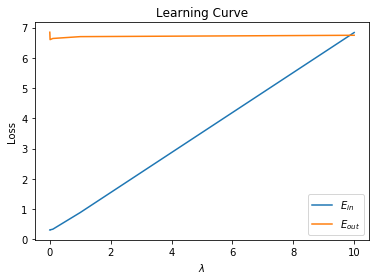

In [17]:
# Split the data into training and test sets
train_data = data[:109351].values
test_data = data[109351:].values
regs = [1e-4,1e-3, 1e-2, 1e-1, 1, 1e1] #regularization params
eta = 0.01 # learning rate
k = 20 #latent features
M = max(max(train_data [:,0]), max(test_data[:,0])).astype(int)+1 # users
N = max(max(train_data [:,1]), max(test_data[:,1])).astype(int)+1 # movies
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
    U,V, e_in = train_model(M, N, k, eta, reg, train_data)
    E_ins.append(e_in)
    eout = get_err(U, V, test_data)
    print(f"Eout mean regularized squared-error= {eout}")
    print('----------------------------------')
    E_outs.append(eout)

# Plot learning curve
plt.plot(regs, E_ins, label='$E_{in}$')
plt.plot(regs, E_outs, label='$E_{out}$')
plt.title('Learning Curve')
plt.xlabel('$\lambda$')
plt.ylabel('Loss')
plt.legend()
plt.show()

### It appears that the model does not have good out of sample performance regardless of regularization.

In [18]:
def UV_proj(U,V):
    '''
    A function for projecting latent features from matrix factorization
    '''
    #decompose V
    A,Sigma,B = np.linalg.svd(V)
    #take first two columns 
    A_12 = A[:,:2]
    #project features
    U_proj = A_12.T@U
    V_proj = A_12.T@V
    #scale V_proj
    for i in range(len(V_proj)):
        V_proj[i] = (V_proj[i]-np.mean(V_proj[i]))/np.std(V_proj[i])
    
    return U_proj,V_proj

In [19]:
#fit data based on parameter screen
eta = 0.01
k=20
reg=0.01
U,V, e_in = train_model(M, N, k, eta, reg, data.values.astype(int))

Epoch 0: Ein mean regularized squared-error= 1.1636787010312446
Epoch 3: : Ein mean regularized squared-error = 0.35787042977938505
----------------------------------
Model building complete.
----------------------------------


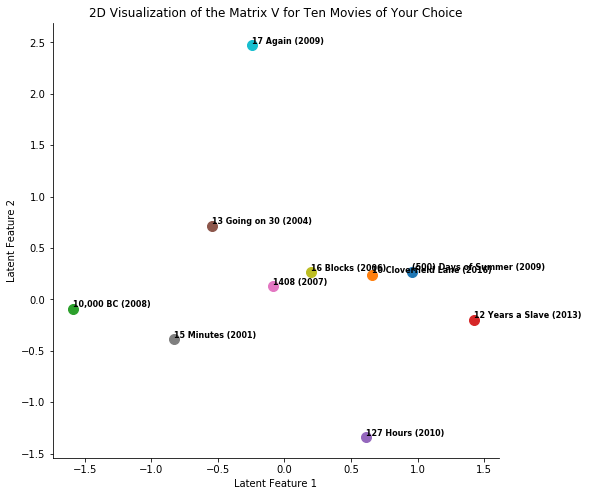

In [20]:
#calculate projections
U_projected, V_projected = UV_proj(U.T, V.T)

# Choose ten movies of your choice
movie_ids = np.arange(0,10,1)
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()

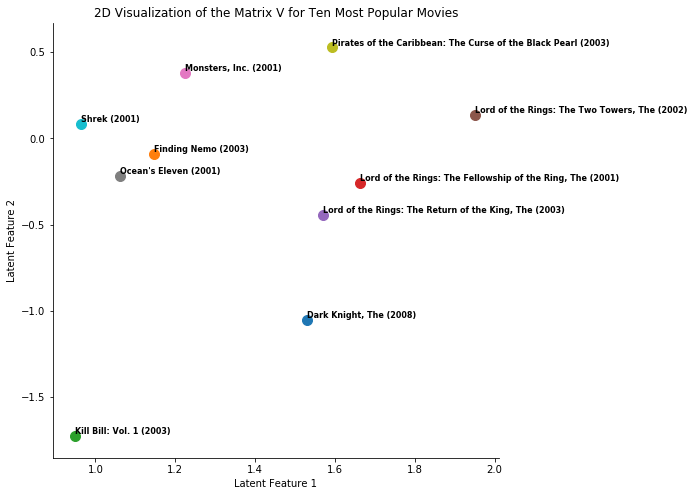

In [21]:
# Choose ten most popular
movie_ids = data.groupby('Movie ID').agg({'Rating': 'count'}).sort_values(by='Rating', ascending=False).head(10).index

selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Most Popular Movies')
plt.show()

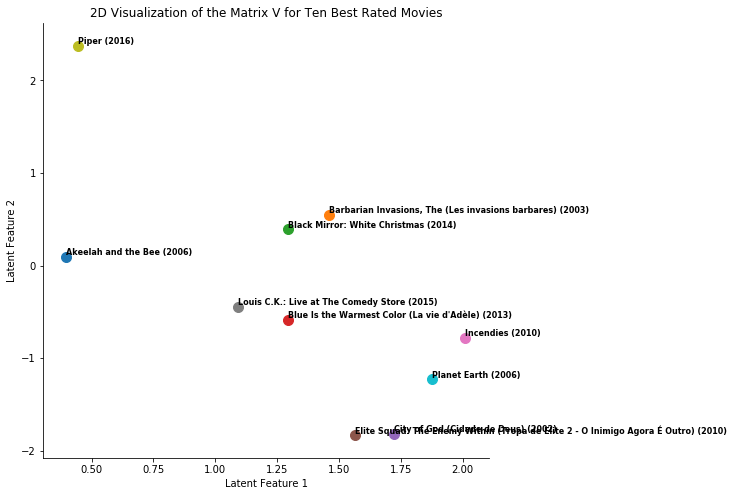

In [22]:
# Choose ten movies best rated
movie_ids = data.groupby('Movie ID').agg({'Rating': 'mean'}).sort_values(by='Rating', ascending=False).head(10).index

selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Best Rated Movies')
plt.show()

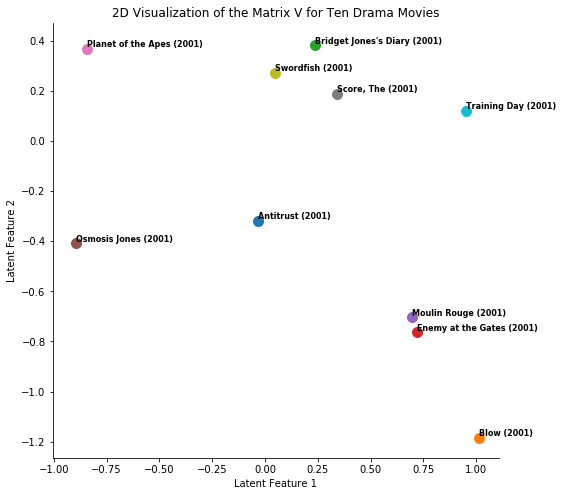

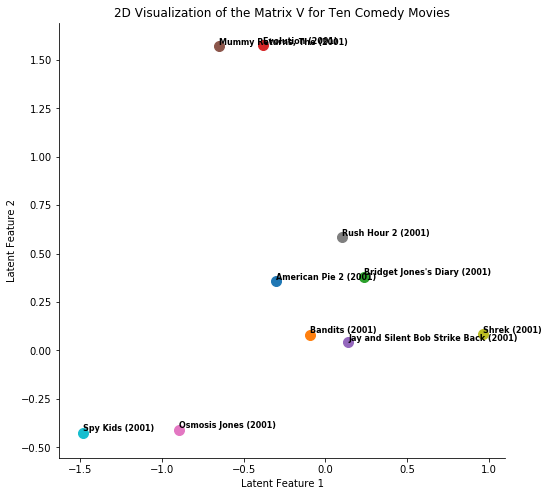

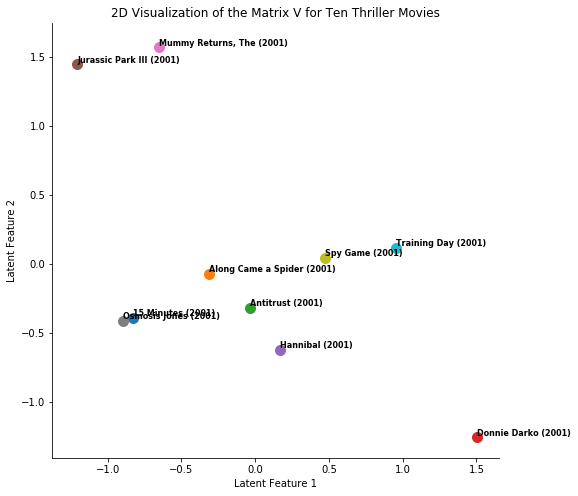

In [23]:
# Choose ten movies from 3 genres
for genre in genres:
    movie_genres =  data[data['Movie ID'].isin(movies[movies[genre] == 1]['Movie ID'])]
    movie_ids = movie_genres.head(10)['Movie ID'].values
    selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
    # Plot the 2D visualization of the matrix V for the selected movies
    plt.figure(figsize=(8, 8))
    for i, movie in enumerate(selected_movies['Movie Title']):
        plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                    V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
        plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
                 V_projected[1, selected_movies['Movie ID'].values[i]], movie,
                 ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    sns.despine()
    plt.title(f'2D Visualization of the Matrix V for Ten {genre} Movies')
    plt.show()

# Method 2: Code with bias

In [27]:
def get_err2(U, V, data, a, b, mu):
    """
    Function to caluclate mean squared error
    """
 
    sum_squared_error = 0
    for row in data.itertuples():
        user_id, item_id, actual_rating = row[1], row[2], row[3]
        predicted_rating = mu + a[user_id] + b[item_id] + np.dot(U[user_id, :], V[item_id, :].T)
        error = actual_rating - predicted_rating
        sum_squared_error += error ** 2
        
    mean_squared_error = sum_squared_error/len(data)

    return mean_squared_error

def train_model2(M, N, K, eta, reg, data, eps= 0.0001, max_epochs=100):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    #initialize U and V
    U = np.random.uniform(low=-0.5, high=0.5, size=(M, K))
    V = np.random.uniform(low=-0.5, high=0.5, size=(N, K))
    # Initialize the user and item biases
    user_biases = np.zeros(M)
    item_biases = np.zeros(N)
    # Initialize the user-item matrix with zeros
    Y = np.zeros((M, N))
    for row in data.itertuples():
        Y[row[1], row[2]] = row[3]

    # Define the global average rating
    global_mean = np.mean(Y[np.where(Y != 0)])
    
    #get initial error
    prev_err = get_err2(U, V, data, user_biases, item_biases, global_mean)
    for epoch in range(max_epochs):
        #shuffle data
        np.random.shuffle(Y)
        #run gradient and update
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                if Y[i,j] > 0:
                    e = Y[i,j] - (global_mean + user_biases[i] + item_biases[j] +  np.dot(U[i, :], V[j, :].T))
                    user_biases[i] += eta * (e - reg * user_biases[i])
                    item_biases[j] += eta * (e - reg * item_biases[j])
                    U[i, :] += eta * (e * V[j, :] - reg * U[i, :])
                    V[j, :] += eta * (e * U[i, :] - reg * V[j, :])
                
        #calculate error
        err = get_err2(U, V, data, user_biases, item_biases, global_mean)
        if np.isnan(err):
            print("Some numerical instability was observed...")
            break
        #early stop
        if epoch == 0:
            initial_error_diff = prev_err - err
        if (epoch > 0)  and (prev_err - err < eps*initial_error_diff):
            break
        #store previous
        prev_err = err
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Ein mean squared-error= {err}")
    print(f"Epoch {epoch}: : Ein mean squared-error = {err}")
    print('----------------------------------')
    print('Model building complete.')
    print('----------------------------------')
    return U, V, user_biases, item_biases, err, global_mean

Training model with M = 992, N = 1500, k = 20, eta = 0.001, reg = 1e-05
Epoch 0: Ein mean squared-error= 1.158910972089368
Epoch 20: Ein mean squared-error= 1.003006628083461
Epoch 23: : Ein mean squared-error = 0.9933962388481142
----------------------------------
Model building complete.
----------------------------------
Eout mean squared-error= 1.1525847053206928
----------------------------------
Training model with M = 992, N = 1500, k = 20, eta = 0.001, reg = 0.0001
Epoch 0: Ein mean squared-error= 1.1461962434260322
Epoch 19: : Ein mean squared-error = 1.0179593841138612
----------------------------------
Model building complete.
----------------------------------
Eout mean squared-error= 1.17426651984035
----------------------------------
Training model with M = 992, N = 1500, k = 20, eta = 0.001, reg = 0.001
Epoch 0: Ein mean squared-error= 1.15117789580835
Epoch 20: Ein mean squared-error= 1.0033824569974255
Epoch 29: : Ein mean squared-error = 0.9703756970614251
-----------

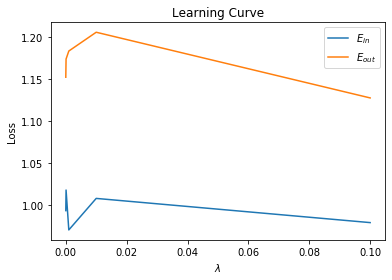

In [28]:
# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]
regs = [1e-5,1e-4,1e-3,1e-2,1e-1] #regularization params
eta = 0.001 # learning rate
k = 20 #latent features
M = max(max(train_data.iloc[:,0]), max(test_data.iloc[:,0])) +1 # users
N = max(max(train_data.iloc[:,1]), max(test_data.iloc[:,1])) +1 # movies
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
    U, V, a, b, err, mu = train_model2(M, N, k, eta, reg, train_data)
    E_ins.append(err)
    eout = get_err2(U, V, test_data, a, b, mu)
    print(f"Eout mean squared-error= {eout}")
    print('----------------------------------')
    E_outs.append(eout)

# Plot learinng curve
plt.plot(regs, E_ins, label='$E_{in}$')
plt.plot(regs, E_outs, label='$E_{out}$')
plt.title('Learning Curve')
plt.xlabel('$\lambda$')
plt.ylabel('Loss')
plt.legend()
plt.show()

### This model seems to generalize better.

In [30]:
#fit data based on parameter screen
eta = 0.001
k = 20
reg = 0.1
U, V, a, b, err, mu = train_model2(M, N, k, eta, reg, data)

Epoch 0: Ein mean squared-error= 1.1561210647571734
Epoch 8: : Ein mean squared-error = 1.0479731195176634
----------------------------------
Model building complete.
----------------------------------


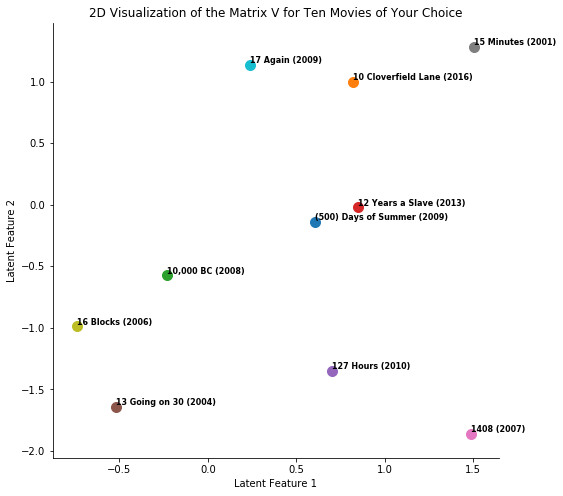

In [31]:
#calculate projections
U_projected, V_projected = UV_proj(U.T, V.T)

# Choose ten movies of your choice
movie_ids = np.arange(0,10,1)
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()

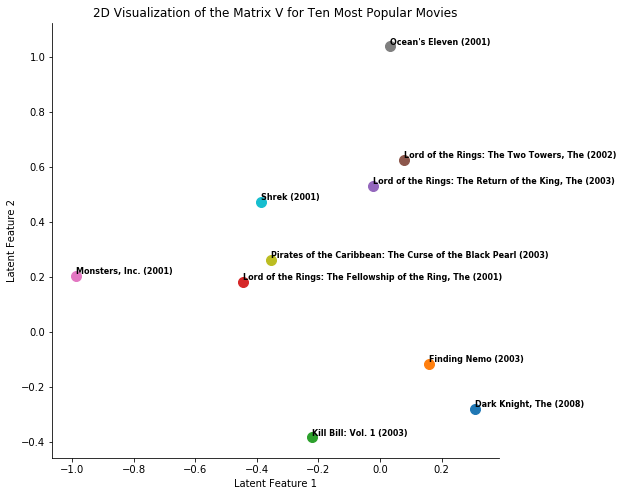

In [32]:
# Choose ten most popular
movie_ids = data.groupby('Movie ID').agg({'Rating': 'count'}).sort_values(by='Rating', ascending=False).head(10).index

selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Most Popular Movies')
plt.show()

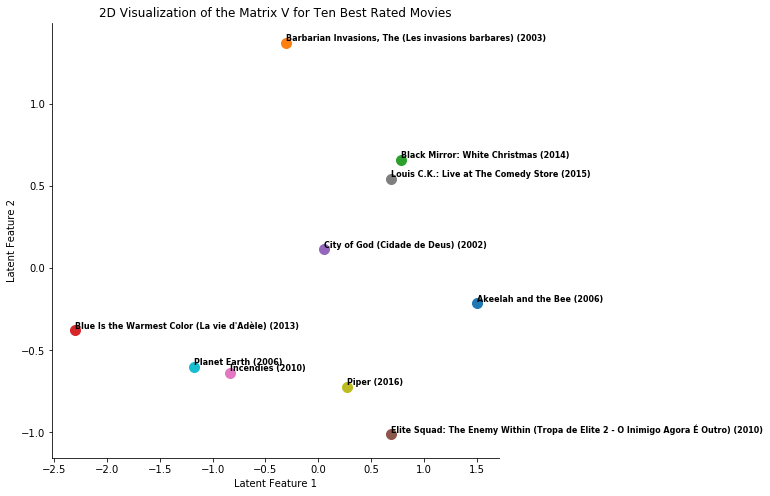

In [33]:
# Choose ten movies best rated
movie_ids = data.groupby('Movie ID').agg({'Rating': 'mean'}).sort_values(by='Rating', ascending=False).head(10).index

selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Best Rated Movies')
plt.show()

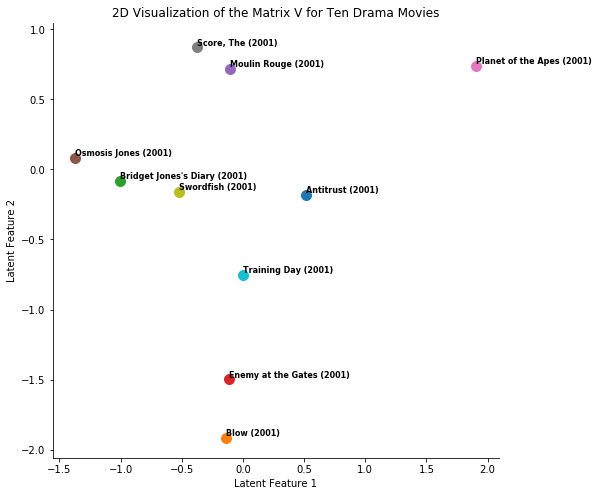

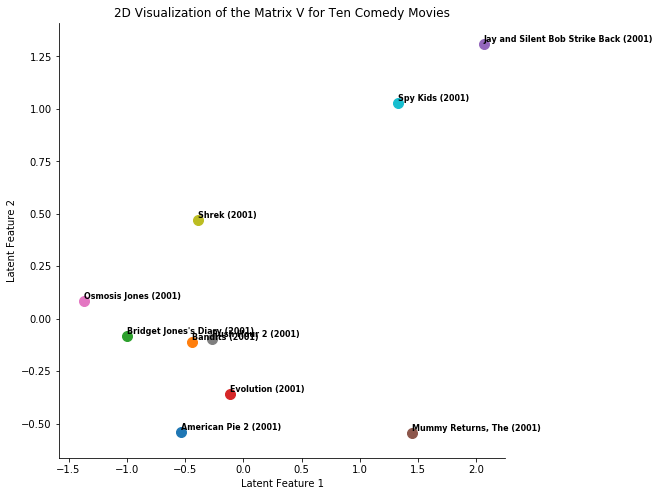

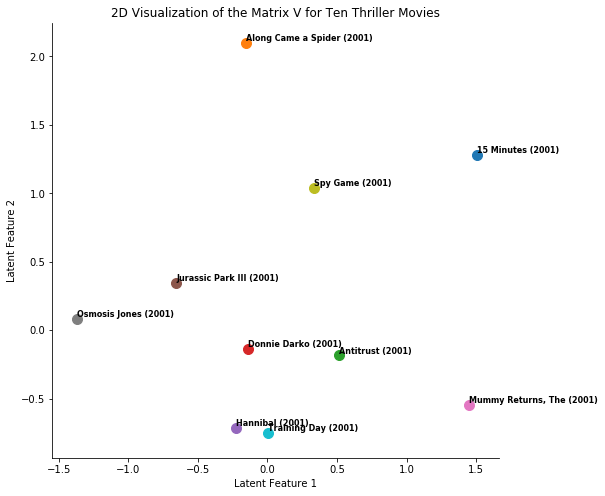

In [34]:
# Choose ten movies from 3 genres
for genre in genres:
    movie_genres =  data[data['Movie ID'].isin(movies[movies[genre] == 1]['Movie ID'])]
    movie_ids = movie_genres.head(10)['Movie ID'].values
    selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
    # Plot the 2D visualization of the matrix V for the selected movies
    plt.figure(figsize=(8, 8))
    for i, movie in enumerate(selected_movies['Movie Title']):
        plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                    V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
        plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
                 V_projected[1, selected_movies['Movie ID'].values[i]], movie,
                 ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    sns.despine()
    plt.title(f'2D Visualization of the Matrix V for Ten {genre} Movies')
    plt.show()

# Code Part 3: Off the shelf

In [4]:
from surprise import SVDpp
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import KFold
from surprise import accuracy
import pandas as pd

# Load the data
data = pd.read_csv('data/data.csv')

# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]

# Define the reader object
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data into the Surprise library format
train_dataset = Dataset.load_from_df(train_data[['User ID', 'Movie ID', 'Rating']], reader)

# Define the search space for the hyperparameters
param_grid = {'n_factors': [10, 20], 'n_epochs': [30, 40], 'reg_bu': [0.1], 'reg_bi': [ 0.1], 'reg_pu': [ 0.1], 'reg_qi': [  0.1], 'reg_yj': [  0.1]}

# Initialize the cross-validation object
kf = KFold(n_splits=5)

# Initialize the RMSE variable to store the best RMSE
best_rmse = float('inf')

# Loop over the hyperparameters
for n_factors in param_grid['n_factors']:
    for n_epochs in param_grid['n_epochs']:
        for reg_bu in param_grid['reg_bu']:
            for reg_bi in param_grid['reg_bi']:
                for reg_pu in param_grid['reg_pu']:
                    for reg_qi in param_grid['reg_qi']:
                        for reg_yj in param_grid['reg_yj']:
                            # Initialize the RMSE for this combination of hyperparameters
                            fold_rmse = []
                            
                            # Loop over the folds
                            for trainset, testset in kf.split(train_dataset):
                                # Fit the SVDpp model to the training data
                                algo = SVDpp(n_factors=n_factors, n_epochs=n_epochs, reg_bu=reg_bu, reg_bi=reg_bi, reg_pu=reg_pu, reg_qi=reg_qi, reg_yj=reg_yj)
                                algo.fit(trainset)
                                
                                # Compute the RMSE on the validation data
                                predictions = algo.test(testset)
                                fold_rmse.append(accuracy.rmse(predictions))
                                
                            # Compute the average RMSE across the folds
                            avg_rmse = np.mean(fold_rmse)
                            
                            # Update the best
                            if avg_rmse < best_rmse:
                                best_rmse = avg_rmse
                                best_params = {'n_factors': n_factors, 'n_epochs': n_epochs, 'reg_bu': reg_bu, 'reg_bi': reg_bi, 'reg_pu': reg_pu, 'reg_qi': reg_qi, 'reg_yj': reg_yj}
print(f'Best RMSE: {best_rmse}')
print(f'Best hyperparameters: {best_params}')


RMSE: 0.8269
RMSE: 0.8301


KeyboardInterrupt: 

In [ ]:
from surprise import SVDpp, NMF, SVD
from surprise import Dataset
from surprise import Reader

# Load the data
data = pd.read_csv('data.csv')

# Split the data into training and test sets
train_data = data[:109351]
test_data = data[109351:]

# Define the reader object
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data into the Surprise library format
train_dataset = Dataset.load_from_df(train_data[['User ID', 'Movie ID', 'Rating']], reader)
test_dataset = Dataset.load_from_df(test_data[['User ID', 'Movie ID', 'Rating']], reader)

# Fit the SVD model to the training data
algo = SVDpp( n_factors = 20, n_epochs = 40, reg_bu = 0.1, reg_bi = 0.1 , reg_pu = 0.1, reg_qi = 0.1 , reg_yj = 0.1 )
algo.fit(train_dataset.build_full_trainset())

In [ ]:
# Get the predictions for the test data
predictions = algo.test(test_dataset.build_full_trainset().build_testset())

# Compute the mean squared error between the actual ratings and the predicted ratings
from surprise import accuracy
test_error = accuracy.rmse(predictions)

In [ ]:
#calculate projections
U_projected, V_projected = UV_proj((algo.pu).T, (algo.qi).T)

# Choose ten movies of your choice
movie_ids = np.arange(0,10,1)
selected_movies = movies[movies['Movie ID'].isin(movie_ids)]

# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Movies of Your Choice')
plt.show()

In [ ]:
# Choose ten movies best rated
movie_ids = data.groupby('Movie ID').agg({'Rating': 'mean'}).sort_values(by='Rating', ascending=False).head(10).index

selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
# Plot the 2D visualization of the matrix V for the selected movies
plt.figure(figsize=(8, 8))
for i, movie in enumerate(selected_movies['Movie Title']):
    plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
    plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
             V_projected[1, selected_movies['Movie ID'].values[i]], movie,
             ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
sns.despine()
plt.title('2D Visualization of the Matrix V for Ten Best Rated Movies')
plt.show()

In [ ]:
# Choose ten movies from 3 genres
for genre in genres:
    movie_genres =  data[data['Movie ID'].isin(movies[movies[genre] == 1]['Movie ID'])]
    movie_ids = movie_genres.head(10)['Movie ID'].values
    selected_movies = movies[movies['Movie ID'].isin(movie_ids)]
    # Plot the 2D visualization of the matrix V for the selected movies
    plt.figure(figsize=(8, 8))
    for i, movie in enumerate(selected_movies['Movie Title']):
        plt.scatter(V_projected[0, selected_movies['Movie ID'].values[i]], 
                    V_projected[1, selected_movies['Movie ID'].values[i]], s=100)
        plt.text(V_projected[0, selected_movies['Movie ID'].values[i]], 
                 V_projected[1, selected_movies['Movie ID'].values[i]], movie,
                 ha='left', va='bottom', fontsize=8,fontweight='bold', wrap=True)
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    sns.despine()
    plt.title(f'2D Visualization of the Matrix V for Ten {genre} Movies')
    plt.show()